In [1]:
from optyx.qpath import *
from optyx.circuit import Phase
from sympy.abc import theta, phi

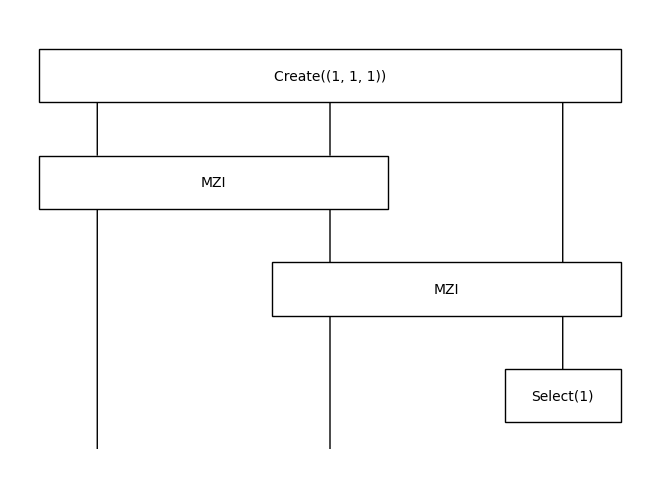

In [2]:
from optyx.circuit import ansatz

circuit = Create(1, 1, 1) >> ansatz(3, 2) >> Id(2) @ Select(1)
circuit.draw()

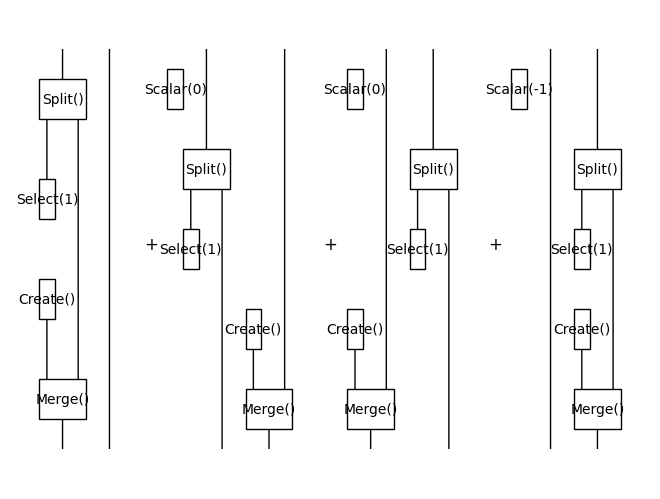

In [3]:
matrix = [
    [1, 0],
    [0, -1]
]

n = len(matrix)
assert len(matrix[0]) == n

terms = []

for i in range(n):
    for j in range(n):
        term = Diagram.from_bosonic_operator(
            n_modes=n,
            operators=[(i, False), (j, True)],
            scalar=matrix[i][j]
        )
        terms.append(term)

hamiltonian = Diagram.sum_factory(terms)

hamiltonian.draw()

In [4]:
expectation = circuit >> hamiltonian >> circuit.dagger()

In [5]:
def to_float(x):
    if isinstance(x, complex):
        assert x.imag < 1e-10, x
        return x.real
    return x

free_syms = list(expectation.free_symbols)

f_exp = lambda xs: to_float(expectation.lambdify(*free_syms)(*xs).eval().array[0, 0])

def d_f_exp(xs):
    return [
        expectation.grad(s).lambdify(*free_syms)(*xs).eval().array[0, 0]
        for s in free_syms
    ]

In [6]:
from tqdm import tqdm

xs = []
fxs = []
dfxs = []

def optimize(x0):
    x = x0

    for _ in tqdm(range(10)):
        fx = f_exp(x)
        dfx = d_f_exp(x)
        
        xs.append(x[::])
        fxs.append(fx)
        dfxs.append(dfx)
        for i, dfxx in enumerate(dfx):
            x[i] = to_float(x[i] - 0.01 * dfxx)

    xs.append(x[::])
    fxs.append(f_exp(x))
    dfxs.append(d_f_exp(x))

In [ ]:
optimize([0.1] * len(free_syms))

 90%|███████████████████████████████████████▌    | 9/10 [00:31<00:03,  3.55s/it]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(xs)),fxs,'b.')
plt.show()